## Файл для веб-камеры (сюда грузим обученную модель)

In [110]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from glob import glob
import sys, os

from sklearn.model_selection import train_test_split

# import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

from facenet_pytorch import MTCNN

In [86]:
# Class ResNet

def conv_block(in_channels, out_channels, pool=False):
    
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
        
    return nn.Sequential(*layers)

def linear_block(input_dim, output_dim, activation = False, dropout = 0.3):
    
    layers = [nn.Linear(input_dim, output_dim),
             nn.Dropout(dropout)]
    if activation:
        layers.append(nn.ReLU())
        
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [87]:
# Загружаю модель, которая создана в HW_10_gcm_prepare.ipynb
gest_model = torch.load('./gesture_classification_model.pth', map_location='cpu')
gest_model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

## Тестирование модели, только ли с камеры такое плохое распознавание?

In [15]:
images = glob('leapGestRecog/**/**/*.png')

In [16]:
labels = [int(os.path.basename(img).split('_')[2])-1 for img in images]

images[:3], labels[:3], len(images), len(labels)

(['leapGestRecog\\00\\01_palm\\frame_00_01_0001.png',
  'leapGestRecog\\00\\01_palm\\frame_00_01_0002.png',
  'leapGestRecog\\00\\01_palm\\frame_00_01_0003.png'],
 [0, 0, 0],
 20000,
 20000)

In [18]:
num_name_list = [(int((os.path.split(img)[0].split('\\')[-1].split('_'))[0])-1, os.path.split(img)[0].split('\\')[-1].split('_')[1:]) for img in images]
num_name_dict = {}
for num, name in num_name_list:
    if num not in num_name_dict.keys():
        num_name_dict[num] = name
        
sorted(num_name_dict.items(), key = lambda x: x[0])

[(0, ['palm']),
 (1, ['l']),
 (2, ['fist']),
 (3, ['fist', 'moved']),
 (4, ['thumb']),
 (5, ['index']),
 (6, ['ok']),
 (7, ['palm', 'moved']),
 (8, ['c']),
 (9, ['down'])]

In [19]:
def num_to_classname(num):
  
    if num == 0:
        return 'palm'
    elif num == 1:
        return 'l'
    elif num == 2:
        return 'fist'
    elif num == 3:
        return 'fist_moved'
    elif num == 4:
        return 'thumb'
    elif num == 5:
        return 'index'
    elif num == 6:
        return 'ok'
    elif num == 7:
        return 'palm_moved'
    elif num == 8:
        return 'c'
    elif num == 9:
        return 'down'

In [20]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=42)

In [21]:
test_tfms =  transforms.Compose([  
                         transforms.Grayscale(num_output_channels=1),
                         transforms.Resize((48,48)),
                         transforms.ToTensor()])
                         # а для теста тольуо перевод в чб и в тензор переводим

In [22]:
class GestRecogDataset(Dataset):
    def __init__(self, images_gestures, labels, transformer):      
        self.images = images_gestures
        self.labels = labels
        self.transformer = transformer

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img =  Image.open(self.images[idx]) 
        img = self.transformer(img)
      
        return img, self.labels[idx]

In [23]:
batch_size = 256

# Create datasets
# train_dataset = GestRecogDataset(X_train, y_train, train_tfms)
test_dataset = GestRecogDataset(X_test, y_test, test_tfms)

# Create dataloaders
# train_loader = DataLoader(train_dataset, batch_size, shuffle = True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

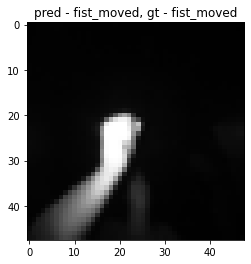

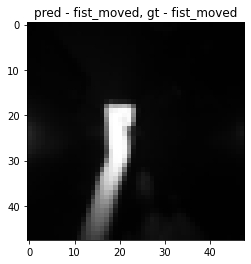

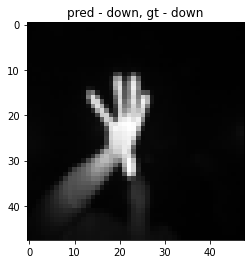

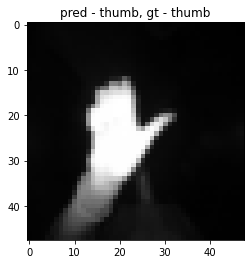

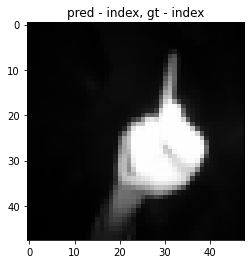

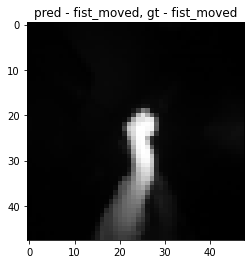

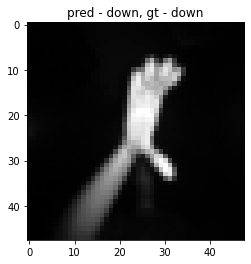

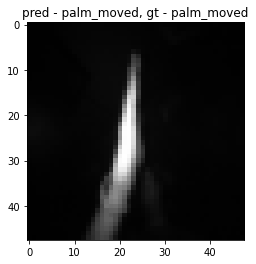

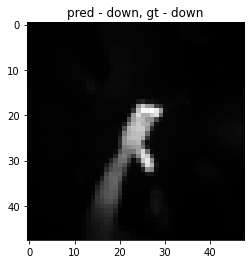

In [27]:
with torch.no_grad():
    for i, data in enumerate(test_loader, 3):
        images, labels = data[0].to('cpu'), data[1].to('cpu')

        outputs = gest_model(images)
        plt.title(f'pred - {num_to_classname(outputs[0].argmax())}, gt - {num_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

## На тесте опять все хорошо, а с вебки плохо, так как яркость с веб-камеры у всех предметов одинаковая - а в датасете рука засвеченная.

## Рабочий вариант без ООП

In [108]:
mtcnn = MTCNN()

video = cv2.VideoCapture(0)


def draw(frame, boxes, probs, landmarks, gestures):
    """
    Draw landmarks and boxes for each face detected
    """
    try:
        for box, prob, ld, gesture in zip(boxes, probs, landmarks, gestures):
            # Draw rectangle on frame
            cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), 
                              (255,255,0), thickness=2)

            # Show probability
            cv2.putText(frame, 
                    gesture, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 0, 255), 2, cv2.LINE_AA)

            # Draw landmarks
#             cv2.circle(frame, tuple([int(i) for i in ld[0]]), 5, (255,255,0), -1)
#             cv2.circle(frame, tuple([int(i) for i in ld[1]]), 5, (255,255,0), -1)
#             cv2.circle(frame, tuple([int(i) for i in ld[2]]), 5, (255,255,0), -1)
#             cv2.circle(frame, tuple([int(i) for i in ld[3]]), 5, (255,255,0), -1)
#             cv2.circle(frame, tuple([int(i) for i in ld[4]]), 5, (255,255,0), -1)
    except:
        pass

    return frame


def crop_faces(frame, boxes):
    faces = []
    for i, box in enumerate(boxes):
        faces.append(frame[int(box[1]):int(box[3]), 
            int(box[0]):int(box[2])])
    return faces


def transform_frame(frame):
    transformer = transforms.Compose([  
                          transforms.ToPILImage(),
                          transforms.Grayscale(num_output_channels=1),
                          transforms.Resize((48,48)),
                          transforms.ToTensor()]) 

    return transformer(frame).unsqueeze(1)
    
    
def num_to_classname(num):
    if num == 0:
        return 'palm'
    elif num == 1:
        return 'l'
    elif num == 2:
        return 'fist'
    elif num == 3:
        return 'fist_moved'
    elif num == 4:
        return 'thumb'
    elif num == 5:
        return 'index'
    elif num == 6:
        return 'ok'
    elif num == 7:
        return 'palm_moved'
    elif num == 8:
        return 'c'
    elif num == 9:
        return 'down'
    
n=0
while (True):
    
    ret, frame = video.read()
    
    try:
        boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)
    
#         face = crop_faces(frame, boxes)[0]
        frame_for_recog = transform_frame(frame)
    
        gesture = gest_model(frame_for_recog)
        gesture = num_to_classname(gesture.argmax())

        draw(frame, boxes, probs, landmarks, gesture)
    
        cv2.imshow("Output",frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    except:
        pass
    
    n += 1
    if n > 20:
        print(gesture)
        n = 0

video.release()
cv2.destroyAllWindows()

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
down
down
down
down
down
down
ok
down
down
ok
ok
ok
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down


## Рабочий вариант ООП

In [115]:
class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.gest_model = torch.load('./gesture_classification_model.pth', map_location=torch.device('cpu'))
        self.gest_model.eval()

    def _draw(frame, boxes, probs, landmarks, gestures):
        """
        Draw landmarks and boxes for each face detected
        """
        try:
            for box, prob, ld, gesture in zip(boxes, probs, landmarks, gestures):
                # Draw rectangle on frame
                cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), 
                                  (255,255,0), thickness=2)

                # Show probability
                cv2.putText(frame, 
                        gesture, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 0, 255), 2, cv2.LINE_AA)

                # Draw landmarks
    #             cv2.circle(frame, tuple([int(i) for i in ld[0]]), 5, (255,255,0), -1)
    #             cv2.circle(frame, tuple([int(i) for i in ld[1]]), 5, (255,255,0), -1)
    #             cv2.circle(frame, tuple([int(i) for i in ld[2]]), 5, (255,255,0), -1)
    #             cv2.circle(frame, tuple([int(i) for i in ld[3]]), 5, (255,255,0), -1)
    #             cv2.circle(frame, tuple([int(i) for i in ld[4]]), 5, (255,255,0), -1)
        except:
            pass

        return frame
    
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
    
    @staticmethod
    def transform_frame(frame):
        transformer = transforms.Compose([  
                              transforms.ToPILImage(),
                              transforms.Grayscale(num_output_channels=1),
                              transforms.Resize((48,48)),
                              transforms.ToTensor()]) 

        return transformer(frame).unsqueeze(1)
        
    @staticmethod
    def num_to_classname(num):
        if num == 0:
            return 'palm'
        elif num == 1:
            return 'l'
        elif num == 2:
            return 'fist'
        elif num == 3:
            return 'fist_moved'
        elif num == 4:
            return 'thumb'
        elif num == 5:
            return 'index'
        elif num == 6:
            return 'ok'
        elif num == 7:
            return 'palm_moved'
        elif num == 8:
            return 'c'
        elif num == 9:
            return 'down'

                  
    def run(self):
        
        video = cv2.VideoCapture(0)
        n=0
        
        while (True):

            ret, frame = video.read()

            try:
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)

        #         face = self.crop_faces(frame, boxes)[0]
                frame_for_recog = self.transform_frame(frame)

                gesture = self.gest_model(frame_for_recog)
                gesture = self.num_to_classname(gesture.argmax())

                self._draw(frame, boxes, probs, landmarks, gesture)

                cv2.imshow("Output",frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            except:
                pass

            n += 1
            if n > 20:
                print(gesture)
                n = 0

        video.release()
        cv2.destroyAllWindows()

In [116]:
# FIRST run
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn)
fcd.run()

down
down
down
down
down
down
down
down
down
down
down


KeyboardInterrupt: 

## Результаты

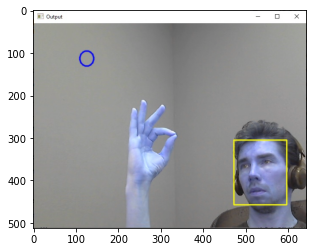

In [103]:
frame = cv2.imread('ok.jpg')
plt.imshow(frame)

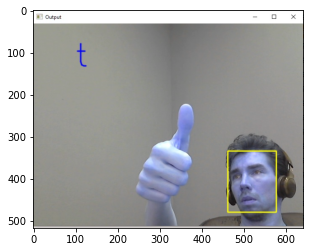

In [104]:
frame = cv2.imread('thumb.jpg')
plt.imshow(frame)

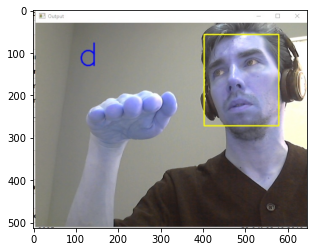

In [109]:
frame = cv2.imread('down.jpg')
plt.imshow(frame)

### Отладка кода

In [107]:
import cv2
cap = cv2.VideoCapture(0)

while(True):
    ret, frame = cap.read()
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('y'): #save on pressing 'y' 
        cv2.imwrite('c1.png',frame)
        cv2.destroyAllWindows()
        break

cap.release()
cv2.destroyAllWindows()

In [72]:
def transform_frame(frame):
    transformer = transforms.Compose([  
                          transforms.ToPILImage(),
                          transforms.Grayscale(num_output_channels=1),
                          transforms.Resize((48,48)),
                          transforms.ToTensor()]) 

    return transformer(frame).unsqueeze(1)

def num_to_classname(num):
    if num == 0:
        return 'palm'
    elif num == 1:
        return 'l'
    elif num == 2:
        return 'fist'
    elif num == 3:
        return 'fist_moved'
    elif num == 4:
        return 'thumb'
    elif num == 5:
        return 'index'
    elif num == 6:
        return 'ok'
    elif num == 7:
        return 'palm_moved'
    elif num == 8:
        return 'c'
    elif num == 9:
        return 'down'

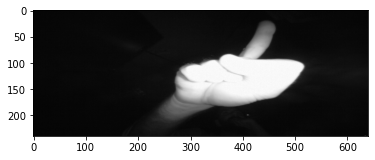

In [81]:
frame = cv2.imread('frame_06_06_0008.png')
plt.imshow(frame)

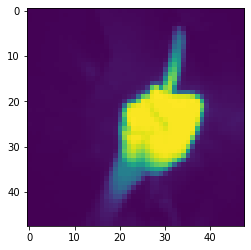

In [82]:
frame_for_recog = transform_frame(frame)
plt.imshow(frame_for_recog[0].permute(1, 2, 0)[:,:,0])

In [83]:
gesture = gest_model(frame_for_recog)
gesture

tensor([[16.4242, 22.9624, 27.0865, 14.8031, 22.8606, 36.5328,  8.8775, 14.5087,
         13.6227,  5.1448]], grad_fn=<AddmmBackward0>)

In [69]:
gesture = gest_model(frame_for_recog)
gesture

tensor([[31.1309, 20.3370, 15.6200, -2.9653, 29.6772, 11.1960, 40.5293, 22.3309,
         22.9704, 12.0735]], grad_fn=<AddmmBackward0>)

In [84]:
gesture = num_to_classname(gesture.argmax())
gesture

'index'